# Analysis of environment surrounding SDSS J0924 using weighted galaxy number counts

The inputs to our anlaysis include:  
* Weighted number counts for the lens field as compared to the HSC SSP DR2 field W05
* Weighted number counts for the millennium simulation
* Values of $\kappa$ and $\gamma$ measured in the Millennium Simulation

These data are avaialable at: (insert link)

In [1]:
#requirements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

data_root = Path("/Volumes/workspace/analysis/0924_final") #REPLACE THIS WITH THE LOCATION ON YOUR MACHINE

#### Loading the Lens Data

There are a total of four files for the lens field weighted number counts. These files have different values of the aperture (max distance from lens to consider) and limiting magnitude. 

Aperture: 45" and 120"
Limiting Magnitude: 23 and 24

Part of the goal of this analysis is to try understand how these different choice affect the final result.

In thise notebook, we will only do the analysis for the 45" aperture with limiting magnitude 24, however this code will reproduce results for any of the combinations.

In [2]:
fname_24_45 = "0924_hscW05_200k_wmindistfilter_i24_45asec_sampled_withmeds.csv"
lens_weight_path = data_root / "lens_weights" / fname_24_45
lens_weights_24_45 = pd.read_csv(lens_weight_path)

#### Loading the Millennium Simulation Data

For each combination of aperture and limiting magnitude, there are 64 total files in the millennium simulation: one for each of the fields.  
For this notebook, we will only consider the 45" aperture with a limiting magnitude of 24.

In [3]:
def load_ms_weights(path: Path):
    files = [f for f in path.glob('*.csv') if not f.name.startswith('.')]
    if len(files) != 64:
        print(f"Warning: Expected 64 MS weight files but only found {len(files)}")
    dfs = [pd.read_csv(f) for f in files]
    return pd.concat(dfs)

ms_weight_path = data_root / "ms" / "45_i24"
ms_weights_24_45 = load_ms_weights(ms_weight_path)
    

#### Clean and normalize the data
There are a couple of bad rows in the lens field weights, and two bad columns in the Milennium Simulation weights.

We normalize the Millennium Simulaton data by dividing by the median value.

In [4]:
pre_l = len(lens_weights_24_45)
lens_weights_24_45.replace([-np.inf, np.inf], np.nan, inplace=True)
lens_weights_24_45.dropna(inplace=True)
print(f"Removed {pre_l - len(lens_weights_24_45)} bad rows from the lens weights")

Removed 4760 bad rows from the lens weights


In [5]:
ms_weights_24_45.drop(["convergencehalo", "convergencehalo_meds"], axis=1, inplace=True)
for column in ms_weights_24_45.columns:
    if column in ['kappa', 'gamma']:
        continue
    vals = ms_weights_24_45[column]
    ms_weights_24_45[column] = vals/np.median(vals)

#### Working with the data
Let's turn these weights into multi-dimensional distributions we can work with.

In [6]:
from copy import copy
def build_distribution(weight_data: pd.DataFrame, weights: list, nbins: int, lower_bounds = 0 , upper_bounds = 3):
    """
    Builds n-dimensional distributions from the field weights, where n is the number of weights being considered
    
    ARGUMENTS:
    
    weight_data: Dataframe containing the field wieghts
    weights: list of weight names being considered
    nbins: number of bins per dimension
    bounds: minimum and maximum value of the weight to consider
    
    RETURNS:
    
    """
    num_los = len(weight_data)
    bins = {}
    nd = len(weights)
    for w in weights:
        wbins = np.linspace(lower_bounds, upper_bounds, nbins)
        bins.update({w: wbins})
    grids = np.meshgrid(*list(bins.values()))
    for k in bins.keys():
        dx = bins[k][-1] - bins[k][-2]
        bins[k] = np.append(bins[k], bins[k][-1] + dx)
    pdf = _iterate_distributions(weight_data, weights, bins)
    pdf = pdf / np.sum(pdf.flatten())
    return grids,bins, pdf

def _iterate_distributions(weight_data, weights, bins):
    """
    Helper functon for the above
    """
    if len(weights) > 1:
        w = weights[0]
        s = tuple([len(a) - 1 for a in bins.values()])
        wbin = bins[w]
        values = np.zeros(s, dtype=np.float32)
        for i, b in enumerate(wbin[:-1]):
            #print(i)
            mask = (weight_data[w] > b) & (weight_data[w] < bins[w][i+1])
            if np.any(mask):
                new_bins = copy(bins)
                new_bins.pop(w)
                values[i] = _iterate_distributions(weight_data[mask], weights[1:], new_bins)
            else:
                values[i] = 0
        return values
    
    elif len(weights) == 1:
        w = weights[0]
        n = np.zeros(len(bins[w]) - 1)
        for i, b in enumerate(bins[w][:-1]):
            mask = ( weight_data[w] > b ) & ( weight_data[w] < bins[w][i+1] )
            nlos = np.count_nonzero(mask)
            n[i] = nlos
        return n
                    

In [7]:
#build an example 2D Distribution for plotting purposes
g, b, pdf = build_distribution(lens_weights_24_45, ["zweight_meds", "oneoverr_meds"], nbins=200)

Text(0, 0.5, 'Redshift weight')

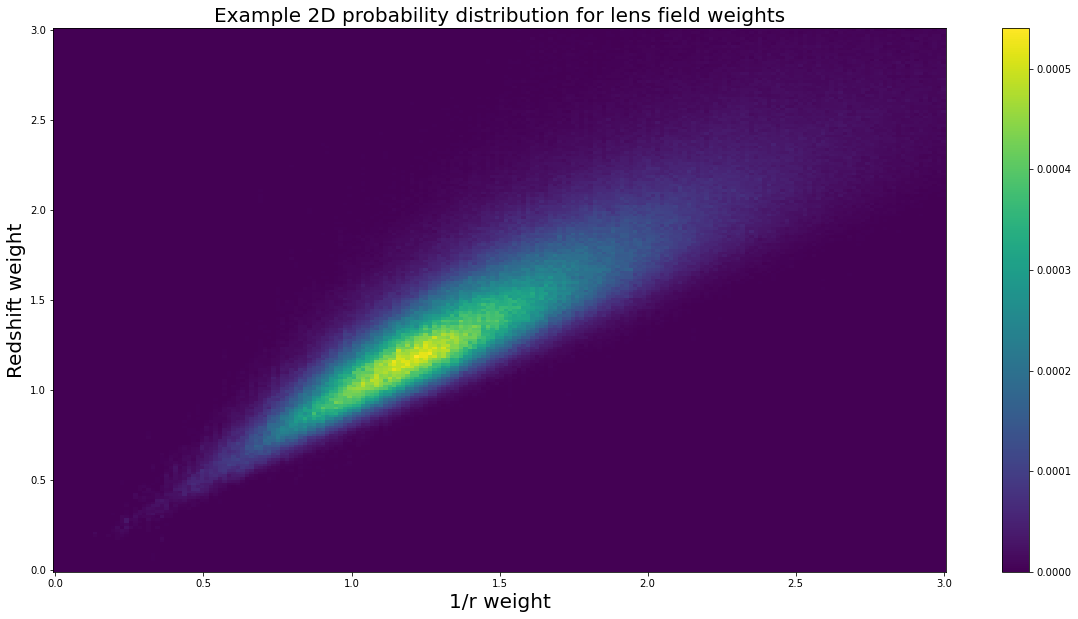

In [8]:
plt.figure(figsize=(20,10))
a = plt.pcolormesh(*g, pdf, shading='auto')
plt.colorbar(a)
plt.title("Example 2D probability distribution for lens field weights", fontsize=20)
plt.xlabel("1/r weight", fontsize=20)
plt.ylabel("Redshift weight", fontsize=20)

#### Computing Kappa

In practice, we want to compute kappa based on more than two weights. We can't visualize this process easily, but our code from above works equally well with more dimensions.

Let's use the simple number counts and the two weights considered above for our analysis.


First we will generate a distribution based on the weights in this lens field. Note this will take *significantly longer* because adding a third dimension increases the number of bins by a factor of nbins (in this case, 200)

I recommend starting this, and then going off to get some coffee. Or a snack. Or go on a short walk? It took about 8.5 minutes on my machine

In [9]:
grid_3d, bins_3d, pdf_3d = build_distribution(lens_weights_24_45, ["gal_meds", "zweight_meds", "oneoverr_meds"], nbins=200)

Now, we need a routine to actually use this information to compute the value of kappa

In [10]:
def compute_kappa_pdf(bins, pdf, ms_data, weights,hist_bins, min_w=0.5, max_w=2.5, *args, **kwargs):
    """
    The function that actually computes the PDF for kappa.
    
    ARGUMENTS:
    
    bins: Second oputput of the build_distribution function
    pdf: third output of the build_distribution function
    ms_data: dataframe containing the millennium simulation wieghts, kappa, and gamma
    weight: name of the weights, should be the same thing you put in build_distribution
    hist_bins: bins you wish to use for kappa
    min_w: minimum value of weights to consider
    max_w: maximum value of weights to consider
    
    
    OPTIONAL ARGUMENTS:
    
    gamma_mid: central value of external shear distribution
    gamma_std: standard deviation of external shear distribution
    
    
    """
    hists = np.zeros(999)
    if len(weights) != pdf.ndim and len(weights) != len(bins):
        return

    gamma_ = kwargs.get("gamma_mid", False)
    if gamma_:
        mid = gamma_
        std_ = kwargs.get("gamma_std")
        gamma_bins = np.linspace(mid -2*std_, mid + 2*std_, 100)
        
        gamma_pdf = norm.pdf(gamma_bins, gamma_, kwargs.get("gamma_std"))
        for i, b_ in enumerate(gamma_bins[:-1]):
            #Note, this does assume gamma is not correlated with the weight values
            if i%10 == 0:
                print(f"Completed {i} out of 100 gamma bins!")
            mask = (ms_data.gamma > b_) & (ms_data.gamma < gamma_bins[i+1])
            res = _iterate_grids(bins, pdf, ms_data[mask], weights, min_w, max_w, hist_bins)
            res = np.array(res)*gamma_pdf[i]
            if len(res) != 0:
                hists += np.sum(res, axis=0)
                
        return hists
    return np.sum(_iterate_grids(bins, pdf, ms_data, weights, min_w, max_w, hist_bins), axis=0)
        
def _iterate_grids(bins, pdf, ms_data, weights, min_w, max_w, hist_bins):
    """
    Helper function for the above. Recursive.
    """
    hists = []
    if len(bins) > 1: #You have more than one weight
        w = weights[0] #Take the first of the weights
        b_ = bins[w]
        for i, b_ in enumerate(bins[w][:-1]): #enumerate over the bins for that weight
            if b_ < min_w or b_ > max_w:
                continue
            mask = (ms_data[w] > b_) & (ms_data[w] < bins[w][i+1]) #Get the MS lines of sight that fall in this bin
            if np.any(mask):
                d_ = copy(bins)
                d_.pop(w)
                result = _iterate_grids(d_, pdf[i], ms_data[mask], weights[1:], min_w, max_w, hist_bins) #Computer histogram for this bin
                if result is not None:
                    hists += result
        return hists
        
    elif len(bins) == 1: #We've made it down to a single weight
        w = weights[0]
        for i, b_ in enumerate(bins[w][:-1]):
            if b_ < min_w or b_ > max_w:
                continue
            mask = (ms_data[w] > b_) & (ms_data[w] < bins[w][i+1])
            if np.any(mask): #Compute the histograms
                hist,h_bins = np.histogram(ms_data[mask]['kappa'], bins = hist_bins)
                hist = hist/np.count_nonzero(mask)
                hist = hist*pdf[i]
                hists.append(hist)
        return hists
                

    

Now let's do the actual computation.  
This took about 3 minutes on my machine.

In [11]:
kappa_bins = np.linspace(-0.1, 0.4, 1000)
kappa_pdf_3d = compute_kappa_pdf(bins_3d, pdf_3d, ms_weights_24_45, ["gal_meds", "zweight_meds", "oneoverr_meds"], kappa_bins,  min_w = 0.5, max_w = 3.0)


In [36]:
#Center, smooth, and normalize
bin_centers = np.array([(kappa_bins[i+1] + kb)*0.5 for i, kb in enumerate(kappa_bins[:-1])])
dk = bin_centers[1] - bin_centers[0]
kernel_size = 30
kernel = np.ones(kernel_size) / kernel_size
kappa_pdf_smoothed = np.convolve(kappa_pdf_3d, kernel, mode='same')
kappa_pdf_normalized = kappa_pdf_smoothed / (np.sum(kappa_pdf_smoothed)*dk)

def get_median(bins, probs):
    half_total = np.sum(probs)/2
    running_total = 0.0
    for index, b in enumerate(bins):
        running_total += probs[index]
        if running_total >= half_total:
            return b
        
kappa_median = get_median(bin_centers, kappa_pdf_normalized)


#### Plot it up

Let's take a look

Text(0.02, 15.0, 'Median = 0.014')

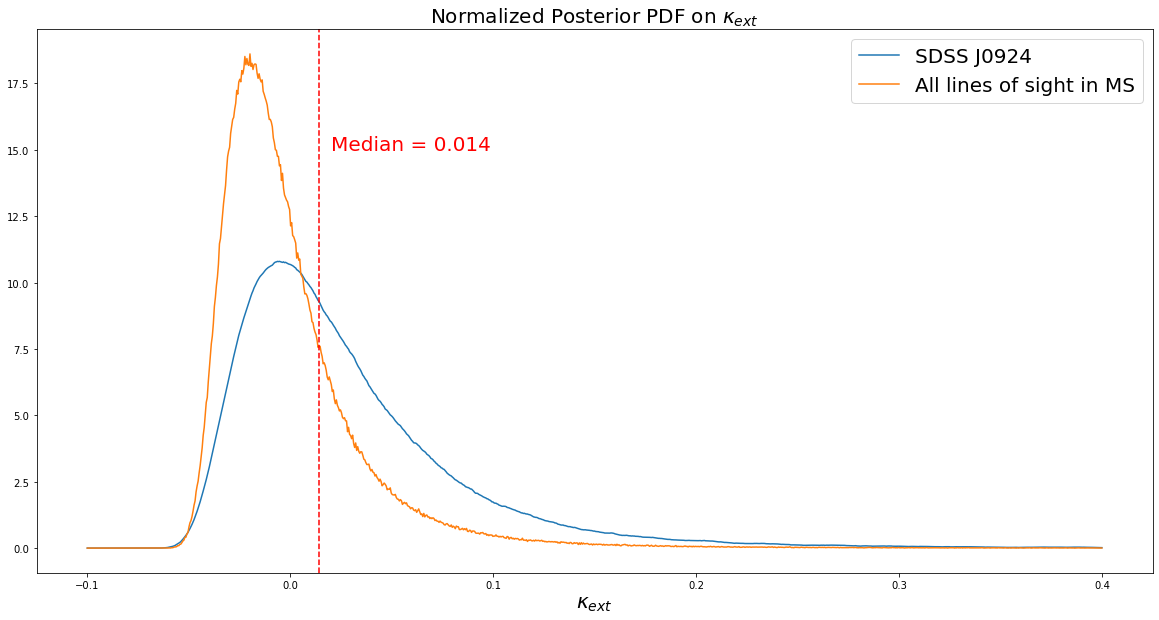

In [45]:
all_los_dist = np.histogram(ms_weights_24_45.kappa, bins=kappa_bins, density=True)

plt.figure(figsize=(20,10))
plt.plot(bin_centers, kappa_pdf_normalized, label="SDSS J0924")
plt.plot(bin_centers, all_los_dist[0], label="All lines of sight in MS")
plt.title("Normalized Posterior PDF on $\kappa_{ext}$", fontsize=20)
plt.legend(fontsize=20)
plt.xlabel("$\kappa_{ext}$", fontsize=20)
plt.axvline(kappa_median, c='red', linestyle='--')
plt.text(0.02, 15.0, f"Median = {round(kappa_median,3)}", c="red", fontsize=20)